# Synthesize Human Speech with WaveNet
※このNotebookは、[chainer/examples/wavenet](https://github.com/chainer/chainer/tree/master/examples/wavenet)を元に作成しています。scriptとして実行したい場合はそちらを参照してください。(現在はまだ[Pull Request](https://github.com/chainer/chainer/pull/4922)。)

このNotebookでは、WaveNet[1]を用いて人の発話を合成します。

まずは、以下のセルを実行して、ChainerとそのGPUバックエンドであるCuPyをインストールします。Colaboratoryの「ランタイムのタイプ」がGPUであれば、GPUをバックエンドとしてChainerを動かすことができます。

In [0]:
!curl https://colab.chainer.org/install | sh -

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 0 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 2s (14.3 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###................

また、学習データのダウンロードの高速化に`aria2`、音声処理に`librosa`、進捗バーの表示に`tqdm`を使うので、ここでインストールします。

In [0]:
!apt -y -q install aria2
!pip install -q librosa tqdm

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libc-ares2
The following NEW packages will be installed:
  aria2 libc-ares2
0 upgraded, 2 newly installed, 0 to remove and 0 not upgraded.
Need to get 1,274 kB of archives.
After this operation, 4,941 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/main amd64 libc-ares2 amd64 1.13.0-2 [37.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu artful/universe amd64 aria2 amd64 1.32.0-1 [1,236 kB]
Fetched 1,274 kB in 1s (1,248 kB/s)

78Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 18431 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.13.0-2_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  9%] [#####.....................................................] 8Unpacking libc-ares2:amd64 (1.13.0-2) ...

## Google ドライブにデータを保存する準備
WaveNetの学習にはとても時間がかかります。そのため、Google Drive に経過を保存できるように、マウントしておきましょう。([参考](https://funmatu.wordpress.com/2017/11/30/colaboratory%E3%81%A7%E7%B0%A1%E5%8D%98%E4%BE%BF%E5%88%A9%E3%81%AB%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AE%E3%82%84%E3%82%8A%E5%8F%96%E3%82%8A%E3%82%92%E3%81%99%E3%82%8B%E6%96%B9%E6%B3%95/))

Colaboratory は、12時間を超えて継続できません。また、90分アイドルが続くと、ランタイムは解放されます。その他の制限は、[こちら](https://qiita.com/tomo_makes/items/b3c60b10f7b25a0a5935)が詳しいです。

次のコードセルをを実行し、以下の手順で Google アカウントの認証を行います。

1. URLが表示されるのでそれをクリック
1.  Google アカウントにログイン
1. 表示されるトークンをコピー
1. このノートに戻って、テキストボックスにそのトークンを貼り付け
1. 再度URLが表示されるのでそれをクリック
1. このノートに戻って、テキストボックスにそのトークンを貼り付け

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools > /dev/null
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse > /dev/null

from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!mkdir -p drive/wavenet

gpg: keybox '/tmp/tmp7ldroxbw/pubring.gpg' created
gpg: /tmp/tmp7ldroxbw/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


必要なモジュールを``import``し、その後にChainerのバージョンやNumPy・CuPy、そしてCuda等の実行環境を確認してみましょう。

In [0]:
import numpy as npter

import chainer
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions


chainer.print_runtime_info()

Chainer: 4.3.1
NumPy: 1.14.5
CuPy:
  CuPy Version          : 4.3.0
  CUDA Root             : None
  CUDA Build Version    : 8000
  CUDA Driver Version   : 9000
  CUDA Runtime Version  : 8000
  cuDNN Build Version   : 7102
  cuDNN Version         : 7102
  NCCL Build Version    : 2212


## 1. 学習データの用意
このnotebookでは、[CSTR VCTK Corpus](http://homepages.inf.ed.ac.uk/jyamagis/page3/page58/page58.html)を学習データとして使用します。CSTR VCTK Corpusは、エジンバラ大学CSTRグループによって収集された様々な英語アクセントをもつ音声コーパスです。発話者は109人，各話者につき400文章程度の文章をよみあげています。以下のセルを実行して、必要な学習データをダウンロードし、解凍しましょう。

In [0]:
!aria2c -x5 http://homepages.inf.ed.ac.uk/jyamagis/release/VCTK-Corpus.tar.gz


08/17 12:01:29 [NOTICE] Downloading 1 item(s)
 *** Download Progress Summary as of Fri Aug 17 12:02:29 2018 *** 
[#1a1973 6.3GiB/10GiB(61%) CN:5 DL:111MiB ETA:37s]
FILE: /content/VCTK-Corpus.tar.gz
-------------------------------------------------------------------------------

[#1a1973 10GiB/10GiB(99%) CN:2 DL:102MiB]
08/17 12:03:08 [NOTICE] Download complete: /content/VCTK-Corpus.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
1a1973|OK  |   107MiB/s|/content/VCTK-Corpus.tar.gz

Status Legend:
(OK):download completed.


In [0]:
!tar -xf VCTK-Corpus.tar.gz

以下のコマンドを実行して学習データが用意できたか確認してみましょう。

In [0]:
!ls ./VCTK-Corpus/wav48

p225  p234  p245  p254	p263  p272  p281  p293	p303  p313  p330  p345	p376
p226  p236  p246  p255	p264  p273  p282  p294	p304  p314  p333  p347
p227  p237  p247  p256	p265  p274  p283  p295	p305  p315  p334  p351
p228  p238  p248  p257	p266  p275  p284  p297	p306  p316  p335  p360
p229  p239  p249  p258	p267  p276  p285  p298	p307  p317  p336  p361
p230  p240  p250  p259	p268  p277  p286  p299	p308  p318  p339  p362
p231  p241  p251  p260	p269  p278  p287  p300	p310  p323  p340  p363
p232  p243  p252  p261	p270  p279  p288  p301	p311  p326  p341  p364
p233  p244  p253  p262	p271  p280  p292  p302	p312  p329  p343  p374


上記の通り、話者ごとにディレクトリが作成されており、その中に音声ファイルが保存されています。

In [0]:
!ls ./VCTK-Corpus/wav48/p225

p225_001.wav  p225_059.wav  p225_142.wav  p225_224.wav	p225_305.wav
p225_002.wav  p225_060.wav  p225_143.wav  p225_225.wav	p225_308.wav
p225_003.wav  p225_061.wav  p225_144.wav  p225_235.wav	p225_309.wav
p225_004.wav  p225_062.wav  p225_145.wav  p225_236.wav	p225_310.wav
p225_005.wav  p225_063.wav  p225_147.wav  p225_237.wav	p225_312.wav
p225_006.wav  p225_064.wav  p225_149.wav  p225_238.wav	p225_314.wav
p225_007.wav  p225_065.wav  p225_150.wav  p225_239.wav	p225_315.wav
p225_008.wav  p225_066.wav  p225_151.wav  p225_240.wav	p225_316.wav
p225_009.wav  p225_067.wav  p225_152.wav  p225_241.wav	p225_317.wav
p225_010.wav  p225_070.wav  p225_153.wav  p225_242.wav	p225_318.wav
p225_011.wav  p225_071.wav  p225_156.wav  p225_243.wav	p225_319.wav
p225_012.wav  p225_072.wav  p225_157.wav  p225_244.wav	p225_320.wav
p225_013.wav  p225_073.wav  p225_158.wav  p225_248.wav	p225_322.wav
p225_014.wav  p225_081.wav  p225_159.wav  p225_253.wav	p225_323.wav
p225_016.wav  p225_082.wav  p225_165.wav  p225_2

ためしに、`p225`ディレクトリ内の1つ目の音声ファイルを再生してみましょう。

In [0]:
import IPython.display
IPython.display.Audio("./VCTK-Corpus/wav48/p225/p225_001.wav")

また、再生するだけでなく、plotもしてみましょう。

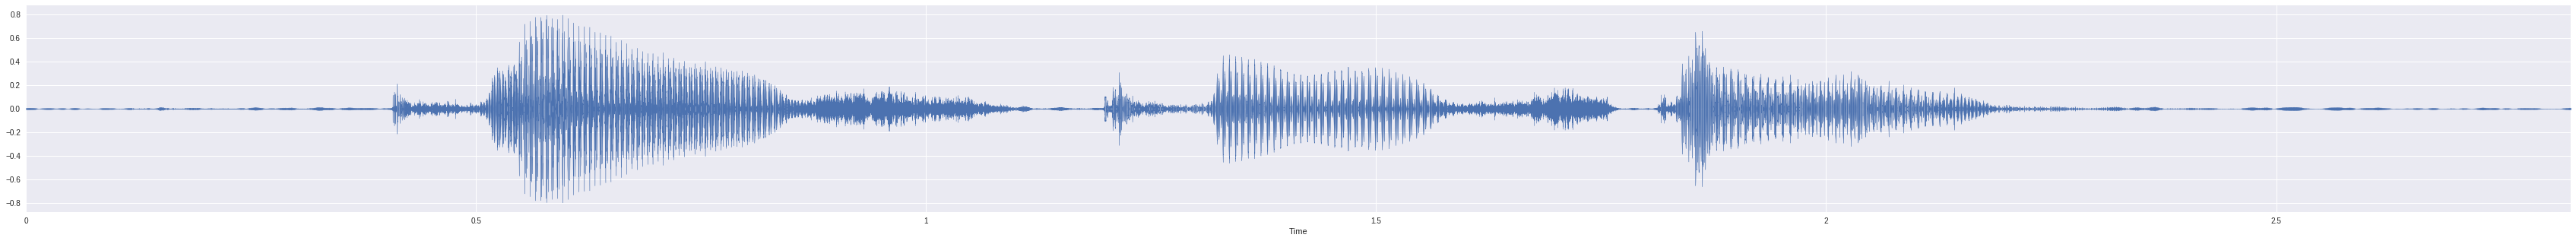

In [0]:
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline


fig = plt.figure(figsize=(60,5))
a = librosa.load("./VCTK-Corpus/wav48/p225/p225_001.wav")
librosa.display.waveplot(a[0], sr=16000)

## 2. パラメータの設定
学習を行う際のパラメータをここで設定します。


In [0]:
# training parameters
batchsize = 4  # Numer of audio clips in each mini-batch
length = 7680  # Number of samples in each audio clip
quantized_size = 256  # Number of quantizing audio data
epoch = 10  # Number of sweeps over the dataset to train
gpu_id = 0
seed = 0  # Random seed to split dataset into train and test

# display parameters
snapshot_interval = 1000  # Interval of snapshot
display_interval = 100  # Interval of displaying log to console

# performance settings
process = 1  # Number of parallel processes
prefetch = 8  # Number of prefetch samples

# file settings
dataset_dir = './VCTK-Corpus'  # Directory of dataset
out_dir = './drive/wavenet/result'  # Directory to output the result

if gpu_id >= 0:
    chainer.global_config.autotune = True

## ３. イテレータの準備

training、validation、testに使用するデータセットを読みこみ、Iteratorを作成しましょう。

まず、下記で音声の前処理に使用する[μ-lawアルゴリズム](https://ja.wikipedia.org/wiki/%CE%9C-law%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0)[2]を定義します。

生の音声は基本的に16-bit($2^{16} = 65,536$)のint値で表現されます。この値を量子化ビット数と言います。もし他クラス識別問題と捉え、softmax cross entropy関数を誤差関数として使った場合、$65,536$の値を出力し、誤差を計算しなくてばなりません。これだと学習するのが難しいため、より小さな量子化ビット数で音声を表現したいという要求が生まれます。

μ-lawアルゴリズムを使うことで、量子化ビット数を16-bitから8-bit($2^{8} = 256$)に下げることができます
。このとき、μ-lawアルゴリズムは以下の特性があるため、効率的に量子化ビット数を下げることができるます。

* 人間の聴覚は対数的に音の強さを知覚するという事実を利用し、対数応答オペアンプを使って信号を対数的に圧縮する
* 圧縮方向だけでなく、伸長方向の演算も用意されており、劣化はするものの音源を再現することができる


μ-lawアルゴリズム圧縮時の式は以下の通りになります。

$$
F(x)=sgn(x) \frac{\log(1+\mu |x|)}{\log(1+\mu)}
$$

また、伸張時の式は以下の通りになります。

$$
F^{-1}(y)=sgn(y)\frac{1}{\mu}[(1+\mu)^{|y|}-1]
$$


In [0]:
import numpy


class MuLaw(object):
    def __init__(self, mu=quantized_size, int_type=numpy.int32, float_type=numpy.float32):
        self.mu = mu
        self.int_type = int_type
        self.float_type = float_type

    def transform(self, x):
        x = x.astype(self.float_type)
        y = numpy.sign(x) * numpy.log(1 + self.mu * numpy.abs(x)) / numpy.log(1 + self.mu)
        y = numpy.digitize(y, 2 * numpy.arange(self.mu) / self.mu - 1) - 1
        return y.astype(self.int_type)

    def itransform(self, y):
        y = y.astype(self.float_type)
        y = 2 * y / self.mu - 1
        x = numpy.sign(y) / self.mu * ((1 + self.mu) ** numpy.abs(y) - 1)
        return x.astype(self.float_type)

上記のように、イニシャライザ``__init__``で``mu=256(quantized_size)``と256段階に量子化するように指定しています。

また、transformで圧縮時の式の定義、itransformで伸張時の式の定義をしています。

次に、データの前処理の全工程を定義しましょう。
前処理では、以下の工程を行います。

1. ファイルから音声データ``raw``の読み込みと正規化
1. 音声データ``raw``をμ-law変換により量子化データ``quantized``に変換
1. 指定した長さ``length``に音声データ``raw``と量子化データ``quantized``をトリミング
1. 音声データ``raw``をメルスペクトログラムに変換
1. メルスペクトログラムを[-1,1]の範囲に正規化
1. それぞれのデータを適切な次元に変換

今回学習するWaveNetは、量子化されたデータを入力にするだけでなく、メルスペクトルグラムも入力に使うことで出力に条件をつけられるようにします。そのため、前処理では量子化データ``quantized``だけでなく、メルスペクトログラム`spectrogram`も作成しています。

注：メルスペクトログラムについてはここを読んでみてください。

* [メル尺度](https://ja.wikipedia.org/wiki/%E3%83%A1%E3%83%AB%E5%B0%BA%E5%BA%A6)
* [スペクトログラム](https://ja.wikipedia.org/wiki/%E3%82%B9%E3%83%9A%E3%82%AF%E3%83%88%E3%83%AD%E3%82%B0%E3%83%A9%E3%83%A0)

実際に実装を見てみましょう。

イニシャライザ``__init__``では、サンプリングレート``sr``、FFTの窓サイズ``n_fft``、窓のスライドサイズ``hop_length``、メルフィルタのバンド数``n_mels``、静音とみなすスレッショルド``top_db``、trim時の音声長``length``、前処理後の量子化ビット数``quantize``を与えています。

``__call__``メソッドでは、上記の工程が定義されています。

In [0]:
import random
import librosa


class Preprocess(object):
    def __init__(self, sr, n_fft, hop_length, n_mels, top_db,
                 length, quantize):
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.top_db = top_db
        self.mu_law = MuLaw(quantize)
        self.quantize = quantize
        if length is None:
            self.length = None
        else:
            self.length = length + 1

    def __call__(self, path):
        # load data with trimming and normalizing
        raw, _ = librosa.load(path, self.sr, res_type='kaiser_fast')
        raw, _ = librosa.effects.trim(raw, self.top_db)
        raw /= numpy.abs(raw).max()
        raw = raw.astype(numpy.float32)

        # mu-law transform
        quantized = self.mu_law.transform(raw)

        # padding/triming
        if self.length is not None:
            if len(raw) <= self.length:
                # padding
                pad = self.length - len(raw)
                raw = numpy.concatenate(
                    (raw, numpy.zeros(pad, dtype=numpy.float32)))
                quantized = numpy.concatenate(
                    (quantized, self.quantize // 2 * numpy.ones(pad)))
                quantized = quantized.astype(numpy.int32)
            else:
                # triming
                start = random.randint(0, len(raw) - self.length - 1)
                raw = raw[start:start + self.length]
                quantized = quantized[start:start + self.length]

        # calculate mel-spectrogram
        spectrogram = librosa.feature.melspectrogram(
            raw, self.sr, n_fft=self.n_fft, hop_length=self.hop_length,
            n_mels=self.n_mels)
        spectrogram = librosa.power_to_db(
            spectrogram, ref=numpy.max)

        # normalize mel spectrogram into [-1, 1]
        spectrogram += 40
        spectrogram /= 40
        if self.length is not None:
            spectrogram = spectrogram[:, :self.length // self.hop_length]
        spectrogram = spectrogram.astype(numpy.float32)

        # expand dimensions
        one_hot = numpy.identity(
            self.quantize, dtype=numpy.float32)[quantized]
        one_hot = numpy.expand_dims(one_hot.T, 2)
        spectrogram = numpy.expand_dims(spectrogram, 2)
        quantized = numpy.expand_dims(quantized, 1)

        return one_hot[:, :-1], spectrogram, quantized[1:]

`dataset_dir`の`wav48/*/*.wav`に該当するファイルのパスをすべて取得し、Datasetを作りましょう。

ここで、`chainer.datasets.TransformDataset`を使います。`TransformDataset`の引数は、リスト状のものと、それを変換する関数で、読み込み時に変換処理を行います。今回の場合、ファイルパスのリスト`paths`と、それを読み込んで特徴量に変換する関数`preprocess`を与えて、`dataset`を作ります。その後、いつも通り`split_dataset_random`を使って、訓練データ`train`と検証データ`valid`に分けます。


In [0]:
import pathlib


paths = sorted([str(path) for path in pathlib.Path(dataset_dir).glob('wav48/*/*.wav')])
preprocess = Preprocess(
    sr=16000, n_fft=1024, hop_length=256, n_mels=128, top_db=20,
    length=length, quantize=quantized_size)
dataset = chainer.datasets.TransformDataset(paths, preprocess)
train, valid = chainer.datasets.split_dataset_random(
    dataset, int(len(dataset) * 0.9), seed)

試しに`dataset`内の1つ目のデータを見てみましょう。

In [0]:
one_hot, spectrogram, quantized = dataset[0]

以下のように、`one_hot`は`shape`が`(256, 7680, 1)`になっています。

- 256は、256段階に量子化したことに由来しています。
- 7680は、`length`で各サンプル長を指定していることに由来しています。

これは各サンプルに対して量子化した値をone-hot vectorにしたものが入っています。

In [0]:
print(one_hot.shape)
print(one_hot[:,0,0])

(256, 7680, 1)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


以下のように、`spectrogram`は`shape`が`(128, 30, 1)`になっています。

- 128は、メルフィルタのバンド数`n_mels`を128にしたことに由来しています。
- 30は、音声データ長`length` を窓のスライドサイズ`hop_length`で割ったもので、$7680 / 256=30$になります。

ここで注意してもらいたいのが、他のデータに比べ、`spectrogram`は`hop_length`の影響でデータ長が短くなっています。そのため、他のデータ長に合わせるため、ネットワークに入力する際にアップサンプリングする必要があります。この後、ネットワークを定義していきますが、そこで`UpsampleNet`を定義しています。これはこの問題を解決するために存在します。

In [0]:
print(spectrogram.shape)
print(spectrogram)

(128, 30, 1)
[[[ 0.4589449 ]
  [ 0.36689636]
  [ 0.17927483]
  ...
  [ 0.24739769]
  [ 0.28995156]
  [ 0.23284094]]

 [[ 0.42147833]
  [ 0.2720798 ]
  [ 0.04488806]
  ...
  [ 0.08610727]
  [ 0.19594899]
  [ 0.10499766]]

 [[ 0.41552567]
  [ 0.2815133 ]
  [-0.0757344 ]
  ...
  [ 0.08881508]
  [ 0.1402724 ]
  [ 0.1095849 ]]

 ...

 [[-0.68776256]
  [-0.8087705 ]
  [-0.9464753 ]
  ...
  [-1.        ]
  [-1.        ]
  [-0.90071553]]

 [[-0.6583122 ]
  [-0.8011834 ]
  [-1.        ]
  ...
  [-1.        ]
  [-1.        ]
  [-0.9762307 ]]

 [[-0.6568792 ]
  [-0.80724776]
  [-1.        ]
  ...
  [-1.        ]
  [-1.        ]
  [-0.9701907 ]]]


以下のように、`quantized`は`shape`が`(7680, 1)`になっています。

- 7680は、`length`で各サンプル長を指定していることに由来しています。

これは各サンプルに対して量子化した回答が入っているので、値としては0~255の数字が入っています。


In [0]:
print(quantized.shape)
print(quantized)

(7680, 1)
[[215]
 [216]
 [218]
 ...
 [ 23]
 [ 23]
 [ 26]]


ここで、いつも通りIteratorを作ります。

In [0]:
# Iterators
train_iter = chainer.iterators.MultiprocessIterator(
    train, batchsize, n_processes=process, n_prefetch=prefetch)
valid_iter = chainer.iterators.MultiprocessIterator(
    valid, batchsize, repeat=False, shuffle=False,
    n_processes=process, n_prefetch=prefetch)


## 4. モデルの準備

使用するネットワークを定義しましょう。今回は以下のようなネットワーク(Fig.1)を作成します。

![Wave Net](https://i.stack.imgur.com/t7qkv.png "Wave Net")

Fig.1 [1]

- `ResidualBlock`は、Fig.1の1つの四角のブロックに該当します。
    - `r_channels`は`ResidualBlock`内で各層が何チャネルを持つか定義しています
    - `s_channels`は各スキップコネクションが何チャネルを持つか定義しています

In [0]:
# Model parameters for ResidualBlock
r_channels = 64  # Number of channels in residual layers and embedding
s_channels = 256  # Number of channels in the skip layers

In [0]:
class ResidualBlock(chainer.Chain):
    def __init__(self, filter_size, dilation,
                 residual_channels, dilated_channels, skip_channels):
        super(ResidualBlock, self).__init__()
        with self.init_scope():
            self.conv = L.DilatedConvolution2D(
                residual_channels, dilated_channels,
                ksize=(filter_size, 1),
                pad=(dilation * (filter_size - 1), 0), dilate=(dilation, 1))
            self.res = L.Convolution2D(
                dilated_channels // 2, residual_channels, 1)
            self.skip = L.Convolution2D(
                dilated_channels // 2, skip_channels, 1)

        self.filter_size = filter_size
        self.dilation = dilation
        self.residual_channels = residual_channels

    def __call__(self, x, condition):
        length = x.shape[2]
        h = self.conv(x)
        h = h[:, :, :length]  # crop
        h += condition
        tanh_z, sig_z = F.split_axis(h, 2, axis=1)
        z = F.tanh(tanh_z) * F.sigmoid(sig_z)
        if x.shape[2] == z.shape[2]:
            residual = self.res(z) + x
        else:
            residual = self.res(z) + x[:, :, -1:]  # crop
        skip_conenection = self.skip(z)
        return residual, skip_conenection

    def initialize(self, n):
        self.queue = chainer.Variable(self.xp.zeros((
            n, self.residual_channels,
            self.dilation * (self.filter_size - 1) + 1, 1),
            dtype=self.xp.float32))
        self.conv.pad = (0, 0)

    def pop(self, condition):
        return self(self.queue, condition)

    def push(self, x):
        self.queue = F.concat((self.queue[:, :, 1:], x), axis=2)

`ResidualBlock`の中では、通常のConvolution層とは異なり、`DilatedConvolution`が使用されています(Fig.2)。
Chainerで`DilatedConvolution`を使いたいときは、[`chainer.links.DilatedConvolution2D`](https://docs.chainer.org/en/stable/reference/generated/chainer.links.DilatedConvolution2D.html)を使えば良いです(実は`chainer.links.Convolution2D`に`dilate`引数を与えても可能です)。

`L.DilatedConvolution2D`の各引数は以下の通りです。例では、2層目から3層目のBlockの実際の値を例示しています。

- `residual_channels`: 入力チャネル数を指定しています。e.g. 64
- `dilated_channels`: 出力チャネル数を指定しています。e.g. 128
- `ksize`: フィルタサイズを指定しています。e.g. (2, 1)
- `pad`: パッディングサイズを指定しています。e.g. (3, 0)
- **dilate**: このクラスの肝心の部分で、dilate size(いくつのデータを飛び飛びで読むか)を指定しています。e.g. (2, 1)


![Dilated Convolution](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif "Dilated Convolution")

Fig.2 [3]

次に、`ResidualBlock`を重ねて、`ResidualNet`を作ります。

- `ResidualNet`は、Fig.1のすべての四角のブロックに該当します。
    - `n_layer`は`ResidualBlock`で隠れ層をいくつ作るか定義しています。Fig.2で言うと、隠れ層の数に該当します。
    - `n_loop`は`ResidualBlock`全体を何回ループさせるかを定義しています。Fig.2の部分を何ループさせるかに該当します。

In [0]:
# Model parameters for ResidualNet
n_layer = 10  # Number of layers in each residual block
n_loop = 4  # Number of residual blocks

In [0]:
class ResidualNet(chainer.ChainList):
    def __init__(self, n_loop, n_layer, filter_size,
                 residual_channels, dilated_channels, skip_channels):
        super(ResidualNet, self).__init__()
        dilations = [2 ** i for i in range(n_layer)] * n_loop
        for dilation in dilations:
            self.add_link(ResidualBlock(
                filter_size, dilation,
                residual_channels, dilated_channels, skip_channels))

    def __call__(self, x, conditions):
        for i, (func, cond) in enumerate(zip(self.children(), conditions)):
            x, skip = func(x, cond)
            if i == 0:
                skip_connections = skip
            else:
                skip_connections += skip
        return skip_connections

    def initialize(self, n):
        for block in self.children():
            block.initialize(n)

    def generate(self, x, conditions):
        for i, (func, cond) in enumerate(zip(self.children(), conditions)):
            func.push(x)
            x, skip = func.pop(cond)
            if i == 0:
                skip_connections = skip
            else:
                skip_connections += skip
        return skip_connections

上記の`Link`を組み合わせて`WaveNet`のネットワークを定義します。

- `WaveNet`は、Fig.1の全体に該当します。`ResidualNet`とConvolution層を組み合わせて作られます。
    - `a_channels`は出力チャネル数を定義しています。
    - `use_embed_tanh`は途中で活性化関数tanhを使用するか定義しています。

In [0]:
# Model parameters for WaveNet
a_channels = quantized_size  # Number of channels in the output layers
use_embed_tanh = True  # Use tanh after an initial 2x1 convolution

In [0]:
class WaveNet(chainer.Chain):
    def __init__(self, n_loop, n_layer, a_channels, r_channels, s_channels,
                 use_embed_tanh):
        super(WaveNet, self).__init__()
        with self.init_scope():
            self.embed = L.Convolution2D(
                a_channels, r_channels, (2, 1), pad=(1, 0), nobias=True)
            self.resnet = ResidualNet(
                n_loop, n_layer, 2, r_channels, 2 * r_channels, s_channels)
            self.proj1 = L.Convolution2D(
                s_channels, s_channels, 1, nobias=True)
            self.proj2 = L.Convolution2D(
                s_channels, a_channels, 1, nobias=True)
        self.a_channels = a_channels
        self.s_channels = s_channels
        self.use_embed_tanh = use_embed_tanh

    def __call__(self, x, condition, generating=False):
        length = x.shape[2]
        x = self.embed(x)
        x = x[:, :, :length, :]  # crop
        if self.use_embed_tanh:
            x = F.tanh(x)
        z = F.relu(self.resnet(x, condition))
        z = F.relu(self.proj1(z))
        y = self.proj2(z)
        return y

    def initialize(self, n):
        self.resnet.initialize(n)

        self.embed.pad = (0, 0)
        self.embed_queue = chainer.Variable(
            self.xp.zeros((n, self.a_channels, 2, 1), dtype=self.xp.float32))

        self.proj1_queue = chainer.Variable(self.xp.zeros(
            (n, self.s_channels, 1, 1), dtype=self.xp.float32))

        self.proj2_queue3 = chainer.Variable(self.xp.zeros(
            (n, self.s_channels, 1, 1), dtype=self.xp.float32))

    def generate(self, x, condition):
        self.embed_queue = F.concat((self.embed_queue[:, :, 1:], x), axis=2)
        x = self.embed(self.embed_queue)
        if self.use_embed_tanh:
            x = F.tanh(x)
        x = F.relu(self.resnet.generate(x, condition))

        self.proj1_queue = F.concat((self.proj1_queue[:, :, 1:], x), axis=2)
        x = F.relu(self.proj1(self.proj1_queue))

        self.proj2_queue3 = F.concat((self.proj2_queue3[:, :, 1:], x), axis=2)
        x = self.proj2(self.proj2_queue3)
        return x

データセットを用意する部分で既に説明しましたが、今回`spectrogram`を条件づけとしてモデルを学習します。

`spectrogram`と他のデータではデータ長が異なるため、`spectrogram`をアップサンプリングする必要があります。`UpsampleNet`はそれを行うためのクラスです。


In [0]:
class UpsampleNet(chainer.ChainList):
    def __init__(self, out_layers, r_channels,
                 channels=[128, 128], upscale_factors=[16, 16]):
        super(UpsampleNet, self).__init__()
        for channel, factor in zip(channels, upscale_factors):
            self.add_link(L.Deconvolution2D(
                None, channel, (factor, 1), stride=(factor, 1), pad=0))
        for i in range(out_layers):
            self.add_link(L.Convolution2D(None, 2 * r_channels, 1))
        self.n_deconvolutions = len(channels)

    def __call__(self, condition):
        conditions = []
        for i, link in enumerate(self.children()):
            if i < self.n_deconvolutions:
                condition = F.relu(link(condition))
            else:
                conditions.append(link(condition))
        return F.stack(conditions)

`WaveNet`を`decoder`、`UpSampleNet`を`encoder`としてモデルを定義しましょう。

In [0]:
class EncoderDecoderModel(chainer.Chain):
    def __init__(self, encoder, decoder):
        super(EncoderDecoderModel, self).__init__()
        with self.init_scope():
            self.encoder = encoder
            self.decoder = decoder

    def __call__(self, x, condition):
        encoded_condition = self.encoder(condition)
        y = self.decoder(x, encoded_condition)
        return y

定義したネットワークを使って、実際に学習を行うmodelを作成しましょう。

In [0]:
# Networks
encoder = UpsampleNet(n_loop * n_layer, r_channels)
decoder = WaveNet(
    n_loop, n_layer, a_channels, r_channels, s_channels, use_embed_tanh)
model = chainer.links.Classifier(EncoderDecoderModel(encoder, decoder))

## 5. Updater・Trainerの準備と学習の実行

いつものように、UpdaterとTrainerを定義して、modelを学習させます。

In [0]:
# Optimizer
optimizer = chainer.optimizers.Adam(1e-4)
optimizer.setup(model)

In [0]:
# Updater and Trainer
updater = chainer.training.StandardUpdater(train_iter, optimizer, device=gpu_id)
trainer = chainer.training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

In [0]:
# Extensions
snapshot_interval = (snapshot_interval, 'iteration')
display_interval = (display_interval, 'iteration')

trainer.extend(extensions.Evaluator(valid_iter, model, device=gpu_id))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(), trigger=snapshot_interval)
trainer.extend(extensions.LogReport(trigger=display_interval))
trainer.extend(extensions.PrintReport(
    ['epoch', 'iteration', 'main/loss', 'main/accuracy',
     'validation/main/loss', 'validation/main/accuracy']),
    trigger=display_interval)
trainer.extend(extensions.PlotReport(
    ['main/loss', 'validation/main/loss'],
    'iteration', file_name='loss.png', trigger=display_interval))
trainer.extend(extensions.PlotReport(
    ['main/accuracy', 'validation/main/accuracy'],
    'iteration', file_name='accuracy.png', trigger=display_interval))
trainer.extend(extensions.ProgressBar(update_interval=10))

(以前に学習させてその途中結果がsnapshotとして、`./drive/wavenet/result/`以下に保存されています。そこから再開させるためのコードです。はじめての場合に実行しても、特に何も起きません。)

In [0]:
import glob


# Resume latest snapshot if exists
model_files = sorted(glob.glob(out_dir + '/snapshot_iter_*'))
if len(model_files) > 0:
  resume = model_files[-1]
  print('model: {}'.format(resume))
  chainer.serializers.load_npz(resume, trainer)

In [0]:
# Run
trainer.run()

## 6. テストデータでの性能の確認

最新の学習結果を使って、実際に音声を合成してみましょう。(最低でも5epochくらいは学習させないと、似た音が出ているか判別できないです。)

In [0]:
if gpu_id != -1:
    chainer.global_config.autotune = True
    use_gpu = True
    chainer.cuda.get_device_from_id(gpu_id).use()
else:
    use_gpu = False

In [0]:
import glob
model_files = sorted(glob.glob(out_dir + '/snapshot_iter_*'))
model_files

[]

In [0]:
model_file = model_files[-1]
input_file = './VCTK-Corpus/wav48/p225/p225_001.wav'
output_file = './drive/wavenet/result.wav'

In [0]:
# Define networks
encoder = UpsampleNet(n_loop * n_layer, r_channels)
decoder = WaveNet(
    n_loop, n_layer,a_channels, r_channels, s_channels, use_embed_tanh)

In [0]:
# Load trained parameters
chainer.serializers.load_npz(
    model_file, encoder, 'updater/model:main/predictor/encoder/')
chainer.serializers.load_npz(
    model_file, decoder, 'updater/model:main/predictor/decoder/')

In [0]:
# Preprocess
_, condition, _ = Preprocess(
    sr=16000, n_fft=1024, hop_length=256, n_mels=128, top_db=20,
    length=None, quantize=a_channels)(input_file)
x = numpy.zeros([1, a_channels, 1, 1], dtype=numpy.float32)
condition = numpy.expand_dims(condition, axis=0)

In [0]:
import tqdm


# Non-autoregressive generate
if use_gpu:
    x = chainer.cuda.to_gpu(x, device=gpu_id)
    condition = chainer.cuda.to_gpu(condition, device=gpu_id)
    encoder.to_gpu(device=gpu_id)
    decoder.to_gpu(device=gpu_id)
x = chainer.Variable(x)
condition = chainer.Variable(condition)
conditions = encoder(condition)
decoder.initialize(1)
output = decoder.xp.zeros(conditions.shape[3])

# Autoregressive generate
for i in tqdm.tqdm(range(len(output))):
    with chainer.using_config('enable_backprop', False):
        out = decoder.generate(x, conditions[:, :, :, i:i + 1]).array
    value = decoder.xp.random.choice(
        a_channels, size=1,
        p=chainer.functions.softmax(out).array[0, :, 0, 0])[0]
    zeros = decoder.xp.zeros_like(x.array)
    zeros[:, value, :, :] = 1
    x = chainer.Variable(zeros)
    output[i] = value

# Save
if use_gpu:
    output = chainer.cuda.to_cpu(output)
wave = MuLaw(a_channels).itransform(output)
librosa.output.write_wav(output_file, wave, 16000)

100%|██████████| 21248/21248 [39:47<00:00,  8.90it/s]


In [0]:
import IPython.display
IPython.display.Audio(output_file)

## Reference
[1] [Aaron van den Oord, Sander Dieleman, Heiga Zen, et al, “WaveNet: A Generative Model for Raw Audio”, arXiv:1609.03499, Sep 2016.](https://arxiv.org/abs/1609.03499)

[2] [μ-lawアルゴリズム](https://ja.wikipedia.org/wiki/%CE%9C-law%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0)

[3] [WaveNet: A Generative Model for Raw Audio](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)